This notebook contains the implementation of the Deep Learning Model used to solve the CT-scan semantic segmentation challenge .

>> Author: Bogdan Aioanei

*Note: If you are not interested in re-training the model from scratch and using the pre-trained model, skip to the "Load the saved model" chapter.*

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

### Load the preprocessed data

In [ ]:
def load_variable_from_local(local_path):
    """
    This function is used load the data saved locally
    
    :param local_path: string path indicating where the variable is located
    :returns: saved variable
    """
    file = open(local_path, 'rb')
    variable = pickle.load(file)
    file.close()
    
    return variable

In [6]:
# load back from local files the previously saved variables
y_test = load_variable_from_local("./y_test2.pckl")
X_test = load_variable_from_local("./X_test.pckl")
y_train = load_variable_from_local("./y_train2.pckl")
X_train = load_variable_from_local("./X_train.pckl")

## Build the U-net model

In [ ]:
# Define some dimensions for the input layer
img_width = 128
img_height = 128
img_channels = 3

# Define the layers of the model using the U-Net Architecture
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))

# -------- Contraction path of U-Net --------
# 1st level
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(inputs)
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv1)
pooling1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)

# 2nd level
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(pooling1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv2)
pooling2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)

# 3rd level
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(pooling2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv3)
pooling3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)

# 4th level
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(pooling3)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv4)
pooling4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)

# 5th level
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(pooling4)
conv5 = tf.keras.layers.Dropout(0.3)(conv5)
conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv5)


# -------- Expansive path of U-Net --------
# 6th level
upsample6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv5)
upsample6 = tf.keras.layers.concatenate([upsample6, conv4])
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(upsample6)
conv6 = tf.keras.layers.Dropout(0.2)(conv6)
conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv6)

# 7th level
upsample7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(conv6)
upsample7 = tf.keras.layers.concatenate([upsample7, conv3])
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(upsample7)
conv7 = tf.keras.layers.Dropout(0.2)(conv7)
conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv7)

# 8th level
upsample8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(conv7)
upsample8 = tf.keras.layers.concatenate([upsample8, conv2])
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(upsample8)
conv8 = tf.keras.layers.Dropout(0.1)(conv8)
conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv8)

# 9th level
upsample9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(conv8)
upsample9 = tf.keras.layers.concatenate([upsample9, conv1], axis = 3)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(upsample9)
conv9 = tf.keras.layers.Dropout(0.1)(conv9)
conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same',
                                             kernel_initializer='he_normal')(conv9)

# output layer
outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

model_unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model_unet.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_unet.summary()

In [ ]:
unet_history = model_unet.fit(X_train, y_train, validation_split = 0.1, batch_size = 32, epochs = 35)

Epoch 1/35
186/186 [==============================] - 38s 190ms/step - loss: 0.1646 - accuracy: 0.9621 - val_loss: 0.1071 - val_accuracy: 0.9793
Epoch 2/35
186/186 [==============================] - 34s 185ms/step - loss: 0.1094 - accuracy: 0.9695 - val_loss: 0.0821 - val_accuracy: 0.9793
Epoch 3/35
186/186 [==============================] - 34s 185ms/step - loss: 0.1086 - accuracy: 0.9695 - val_loss: 0.0869 - val_accuracy: 0.9793
Epoch 4/35
186/186 [==============================] - 34s 185ms/step - loss: 0.1062 - accuracy: 0.9695 - val_loss: 0.0748 - val_accuracy: 0.9793
Epoch 5/35
186/186 [==============================] - 34s 185ms/step - loss: 0.0976 - accuracy: 0.9695 - val_loss: 0.0661 - val_accuracy: 0.9793
Epoch 6/35
186/186 [==============================] - 34s 185ms/step - loss: 0.0812 - accuracy: 0.9716 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 7/35
186/186 [==============================] - 34s 185ms/step - loss: 0.0648 - accuracy: 0.9779 - val_loss: 0.0362 - val_ac

### Save the model

In [ ]:
save_model_path = "./model_unet"
model_unet.save(save_model_path)

INFO:tensorflow:Assets written to: ./model_unet/assets


### Load the saved model

In [2]:
saved_model_path = "./model_unet"
model_unet = tf.keras.models.load_model(saved_model_path)

### Get some predictions

In [ ]:
predictions = model_unet.predict(X_test)

### Evaluate the model

In [ ]:
loss, acc = model_unet.evaluate(X_test, y_test, verbose=1)

56/56 [==============================] - 4s 65ms/step - loss: 0.0183 - accuracy: 0.9943


### Plot some examples

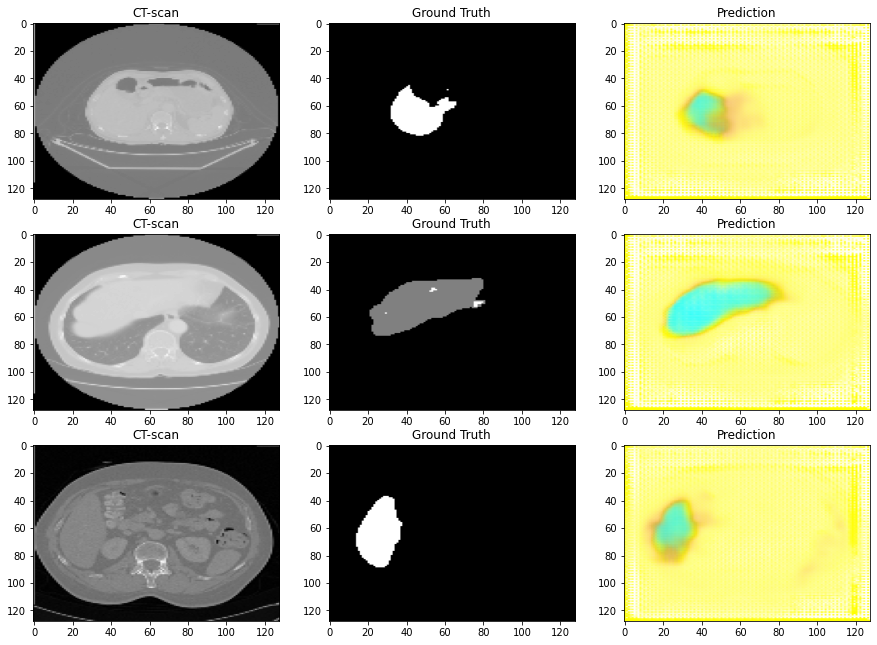

In [29]:
f, axarr = plt.subplots(3,3, figsize = (15, 11))

axarr[0,0].title.set_text('CT-scan')
axarr[0,0].imshow(X_test[991][:,:,0], cmap = 'gray', aspect='auto')
axarr[0,1].title.set_text('Ground Truth')
axarr[0,1].imshow(np.squeeze(y_test[991]), cmap = 'gray', aspect='auto')
axarr[0,2].title.set_text('Prediction')
axarr[0,2].imshow(np.squeeze(predictions[991]), cmap = 'gray', aspect='auto')

axarr[1,0].title.set_text('CT-scan')
axarr[1,0].imshow(X_test[100][:,:,0], cmap = 'gray', aspect='auto')
axarr[1,1].title.set_text('Ground Truth')
axarr[1,1].imshow(np.squeeze(y_test[100]), cmap = 'gray', aspect='auto')
axarr[1,2].title.set_text('Prediction')
axarr[1,2].imshow(np.squeeze(predictions[100]), cmap = 'gray', aspect='auto')

axarr[2,0].title.set_text('CT-scan')
axarr[2,0].imshow(X_test[236][:,:,0], cmap = 'gray', aspect='auto')
axarr[2,1].title.set_text('Ground Truth')
axarr[2,1].imshow(np.squeeze(y_test[236]), cmap = 'gray', aspect='auto')
axarr[2,2].title.set_text('Prediction')
axarr[2,2].imshow(np.squeeze(predictions[236]), cmap = 'gray', aspect='auto')